# 3b. Fitting carbonate and SO$_2$ peaks
- This notebook shows how to fit secondary peaks, such as carbonate and S-rich phases in vapour bubbles and fluid inclusions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from tqdm import tqdm
pf.__version__

'1.0.1'

In [2]:
# Here, we are loading in the settings files from Step1. If all you want to do is find secondary phases, paste that code here
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

In [3]:
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'diad','Spec', 'CRR', 'secphase','Series','unquant']
Diad_Files=pf.get_files(path=spectra_path, file_ext=spectra_file_ext, exclude_str=exclude_str)
print(Diad_Files)
File_df=pd.DataFrame(data={'filename': Diad_Files})

['04 FG19-101-A-50X-rep1.txt', '05 FG19-101-A-50X-rep2.txt', '06 FG19-101-A-50X-rep3.txt', '07 FG19-101-A-50X-12mw.txt', '09 187-1-201-MI1-rep1.txt', '10 187-1-201-MI1-rep2.txt', '11 187-1-201-MI1-rep3.txt', '14 187-1-201-FI2.txt', '15 187-1-201-FI3.txt', '16 187-1-201-FI4.txt', '17 187-1-201-FI5.txt', '27 187-1-203-xtal4-FI1.txt', '30 187-1-203-xtal4-FI2.txt', '31 187-1-204-MI1-rep1.txt', '32 187-1-204-MI1-rep2-20mw.txt', '34 187-1-204-FI1.txt', '35 187-1-204-FI2.txt', '37 187-1-205-MI1.txt', '42 187-1-206-MI1.txt', '44 FG19-101-A-50X-rep4.txt', '45 FG19-101-A-50X-rep5.txt', '46 FG19-101-A-50X-rep6.txt']


## Plot spectra in a given region of space to examine secondary peaks or not

### You'll need to tweak the peak parameters to find them
- height = minimum height a peak should have to be identified
- threshold = required vertical distance between a peak and its neighbours
- distance = required horizontal distance bewteen neighbouring peaks. 
- prominence = required prominence of peaks
- width = width of peaks


## Example 1 - Using Scipy find peaks to look for SO2

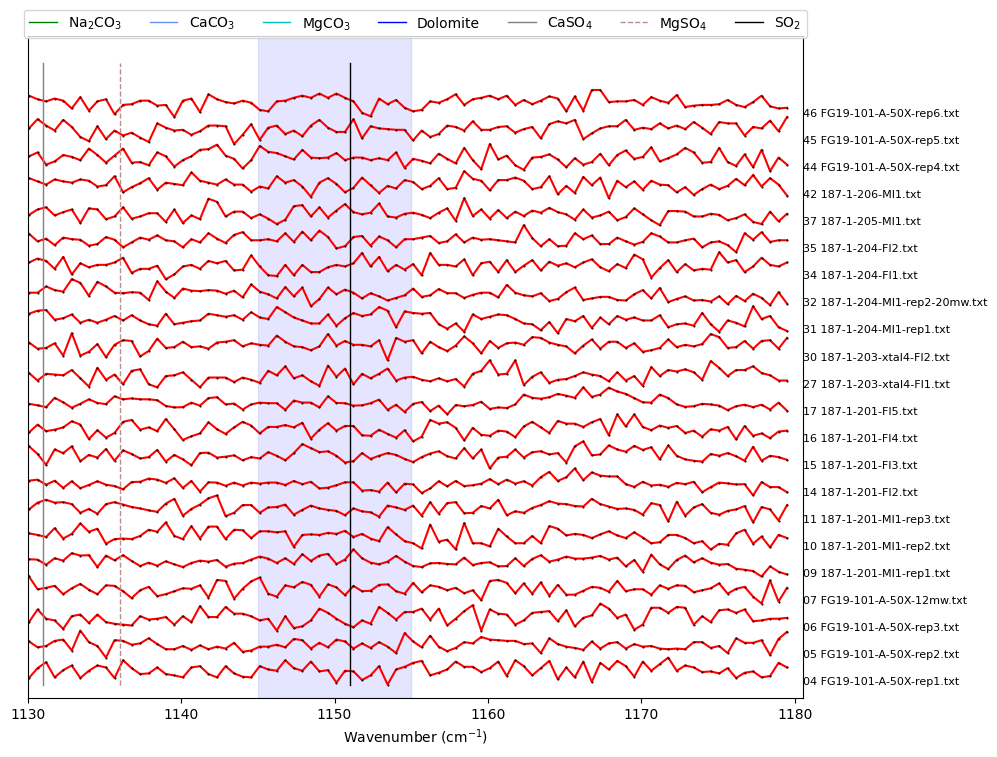

In [4]:
prominence_SO2=20
height_SO2=20
width_SO2=1
threshold_SO2=1

SO2_peaks_scipy, x_data_scipy, y_data_scipy, fig_scipy=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
filetype=spectra_filetype, find_peaks_filter=True,  
xlim_peaks=[1145, 1155], xlim_plot=[1130, 1180], yscale=0.3,
prominence=prominence_SO2, height=height_SO2, width=width_SO2, threshold=threshold_SO2)

SO2_peaks=SO2_peaks_scipy

In [5]:
SO2_peaks

,pos,height,prom,file_names
0,NaN,NaN,NaN,04 FG19-101-A-50X-rep1.txt
1,NaN,NaN,NaN,05 FG19-101-A-50X-rep2.txt
2,NaN,NaN,NaN,06 FG19-101-A-50X-rep3.txt
3,NaN,NaN,NaN,07 FG19-101-A-50X-12mw.txt
4,NaN,NaN,NaN,09 187-1-201-MI1-rep1.txt
5,NaN,NaN,NaN,10 187-1-201-MI1-rep2.txt
6,NaN,NaN,NaN,11 187-1-201-MI1-rep3.txt
7,NaN,NaN,NaN,14 187-1-201-FI2.txt
8,NaN,NaN,NaN,15 187-1-201-FI3.txt
9,NaN,NaN,NaN,16 187-1-201-FI4.txt


### Now filter out ones with no peaks, or low prominence before we loop through them

In [6]:
# Remove the ones where it didnt find SO2
SO2_notNa=np.isnan(SO2_peaks['pos'])
# Remove ones with a prominence less than this. 
prom_filt=35
SO2_filter=((SO2_peaks['prom']>prom_filt))&(~SO2_notNa)
print('Number kept with this filter:')
print(sum(SO2_filter))
print('Number discarded:')
print(sum(~SO2_filter&(~SO2_notNa)))
filenames_SO2=list(File_df['filename'].loc[SO2_filter])
print('filenames with SO2:')
print(filenames_SO2)

Number kept with this filter:
0
Number discarded:
0
filenames with SO2:
[]


### Choose a filename to test peak fits

In [7]:
if sum(SO2_filter)>0:
    filename=filenames_SO2[0]

### Set up configuration file for S peak fitting
- Here, we are using a spline to quantify the area down to the 92% of the peak height (int_cut_of=0.08), there are differen options you can use for this

In [8]:
if sum(SO2_filter)>0:
    SO2_peak_config=pf.generic_peak_config(name='SO2', lower_bck=[1110, 1130],
    upper_bck=[1190, 1200], cent=1150, x_range_bck=20, N_peaks=1,   model_name='Spline', int_cut_off=0.05)
    print(SO2_peak_config)

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
    path=spectra_path, filename=filename, filetype=spectra_filetype, 
     plot_figure=True)

## Now lets loop through files

In [9]:
files_to_fit=filenames_SO2
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_SO2 = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
path=spectra_path, filename=filename, filetype=spectra_filetype,
 plot_figure=plot_figure)
 
    df_Merge_SO2 = pd.concat([df_Merge_SO2, SO2_peak_fit], axis=0)

0it [00:00, ?it/s]


In [10]:
df_Merge_SO2

""


### Plot peak areas and peak heights

In [11]:
if sum(SO2_filter)>0:
    plt.plot(df_Merge_SO2['Peak_Area_SO2'], 
            df_Merge_SO2['Peak_Height_SO2'], 'ok')
    plt.xlabel('Peak Area SO2')
    plt.ylabel('Peak Height SO2')
    # plt.yscale('log')
# plt.xscale('log')

### Save this to excel

In [12]:
if sum(SO2_filter)>0:
    df_Merge_SO2['filename'] = df_Merge_SO2['filename'].str.replace('--Spec.Data 1', '')
    df_Merge_SO2.to_excel('SO2_Peak_fits.xlsx', index=False)

## Now do the same to ID any carbonate peaks

### Using scipy find peaks methods
- This method doesnt always work perfectly for broader carbonate peaks

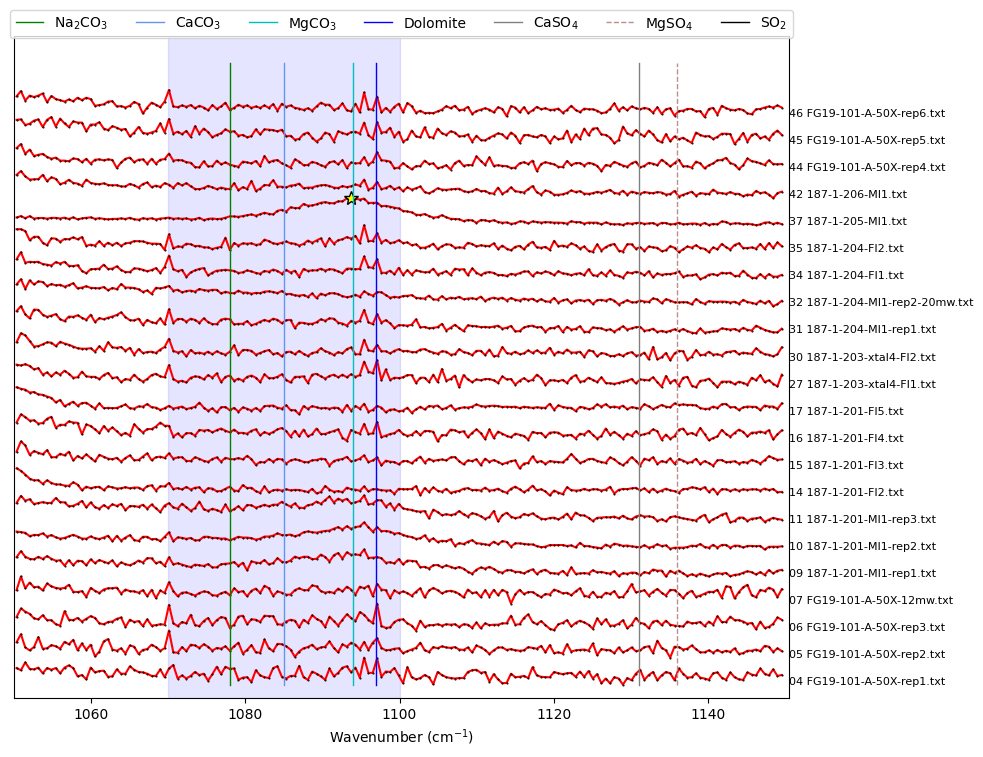

In [13]:

prominence_carb=30
height_carb=10
width_carb=1
threshold_carb=1

Carb_peaks_scipy, x_data_scipy, y_data_scipy, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=spectra_filetype, find_peaks_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1070, 1100], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)
Carb_peaks=Carb_peaks_scipy

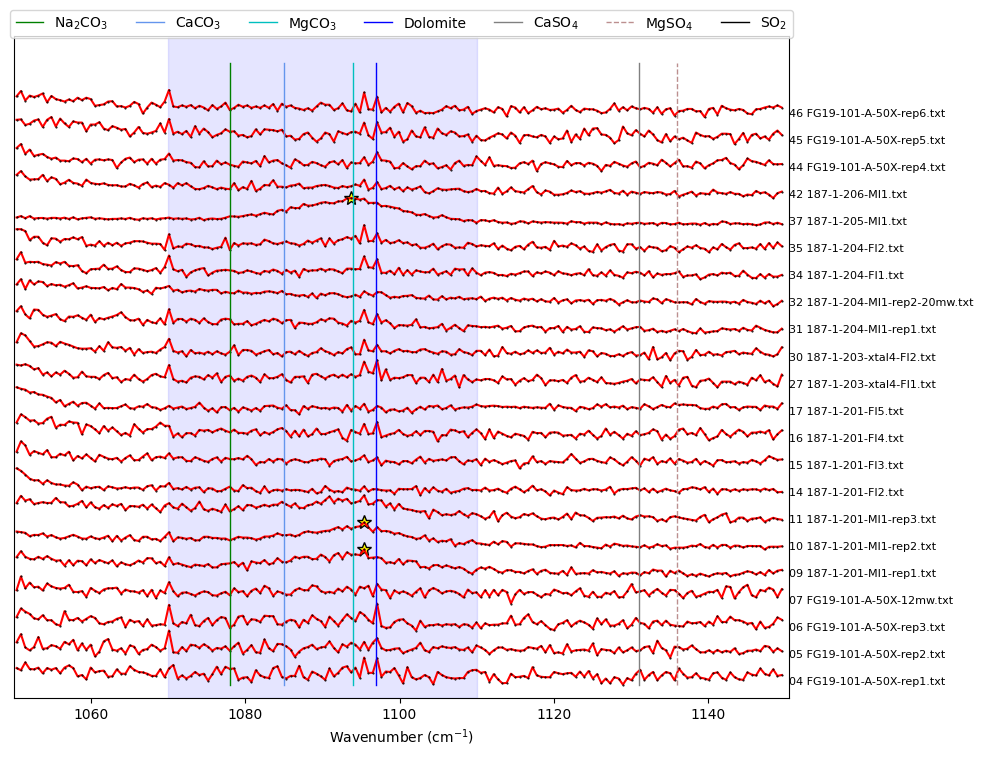

In [23]:

prominence_carb=25
height_carb=10
width_carb=1
threshold_carb=1

Carb_peaks_prom, x_data_prom, y_data_prom, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=spectra_filetype, prominence_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1070, 1110], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)

Carb_peaks=Carb_peaks_prom

## Find ones with certain peak parameters to include

In [25]:
Carb_noNa=np.isnan(Carb_peaks['pos'])
prom_filter=20
Carb_filter=((Carb_peaks['prom']>prom_filter))&(~Carb_noNa)
print('Number kept with this filter:')
print(sum(Carb_filter))
print('Number discarded:')
print(sum(~Carb_filter&(~Carb_noNa)))
filenames_Carb=list(File_df['filename'].loc[Carb_filter])
print('filenames with carb:')
print(filenames_Carb)

Number kept with this filter:
3
Number discarded:
0
filenames with carb:
['09 187-1-201-MI1-rep1.txt', '10 187-1-201-MI1-rep2.txt', '37 187-1-205-MI1.txt']


### Fit one to tweak parameters

generic_peak_config(name='Carb', lower_bck=[1050, 1070], upper_bck=[1120, 1150], model_name='Spline', x_range_bck=50, N_poly_carb_bck=2, amplitude=1000, cent=1090, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=None, return_other_params=False, N_peaks=1, int_cut_off=0.05)


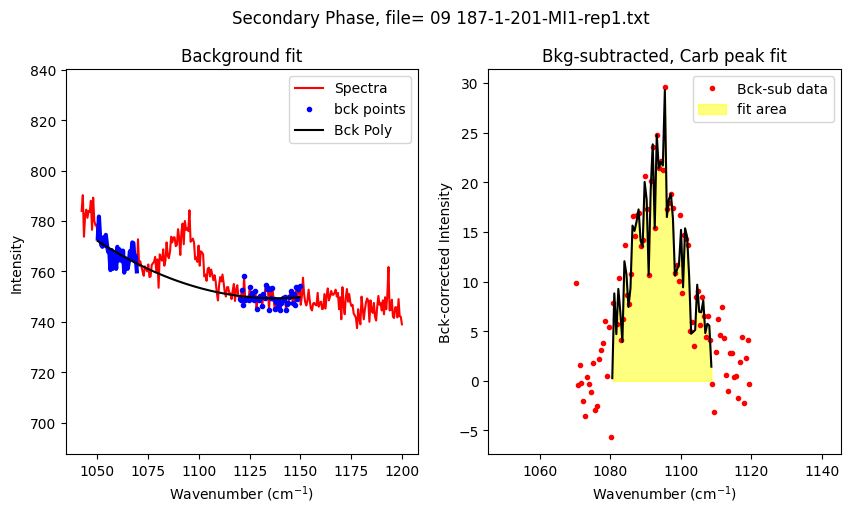

In [26]:
if sum(Carb_filter)>0:
    filename_carb=filenames_Carb[0]

    Carb_peak_config=pf.generic_peak_config(name='Carb', lower_bck=[1050, 1070],
    upper_bck=[1120, 1150], cent=1090, x_range_bck=50, N_poly_carb_bck=2, model_name='Spline')
    print(Carb_peak_config)

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
    path=spectra_path, filename=filename_carb, filetype=spectra_filetype,
     plot_figure=True)

### Loop over all carbonate files

100%|██████████| 3/3 [00:00<00:00,  5.77it/s]


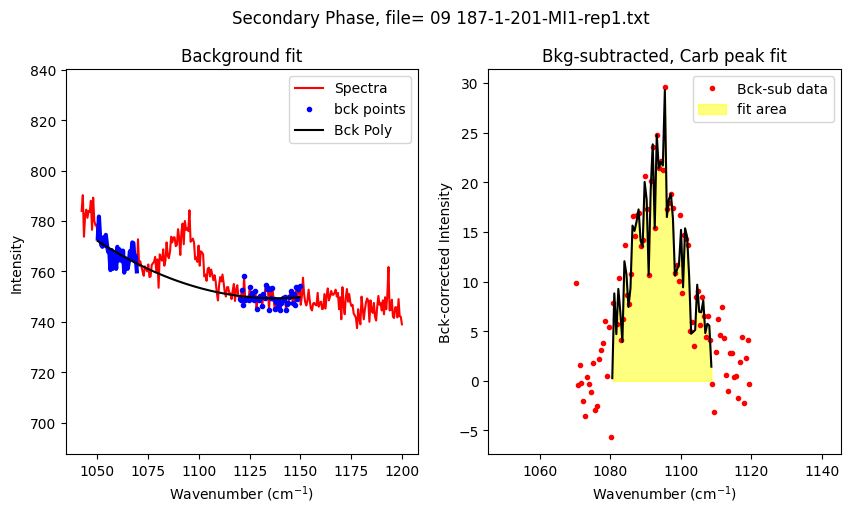

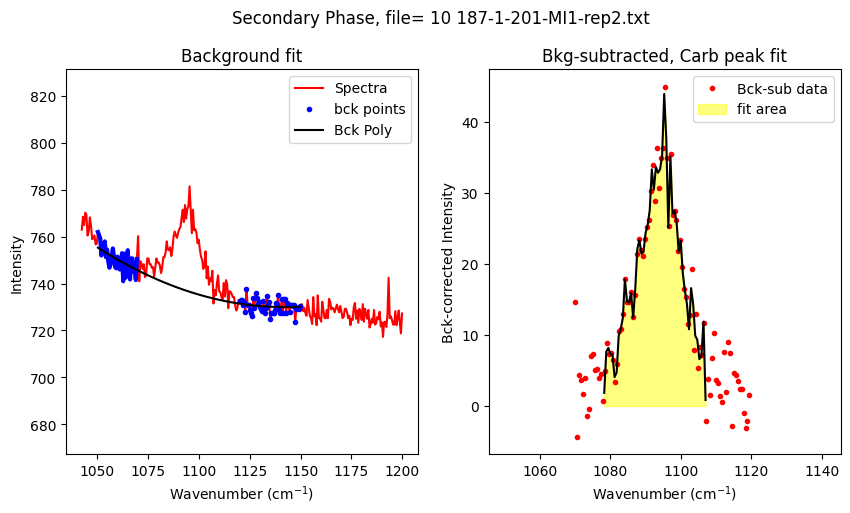

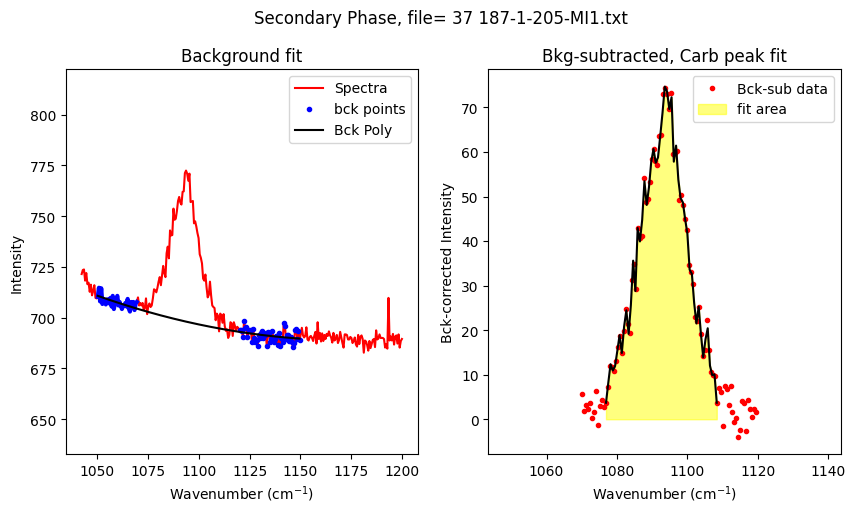

In [27]:
files_to_fit=filenames_Carb
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_Carb = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
path=spectra_path, filename=filename, filetype=spectra_filetype,
 plot_figure=plot_figure)
 
    df_Merge_Carb = pd.concat([df_Merge_Carb, Carb_peak_fit], axis=0)

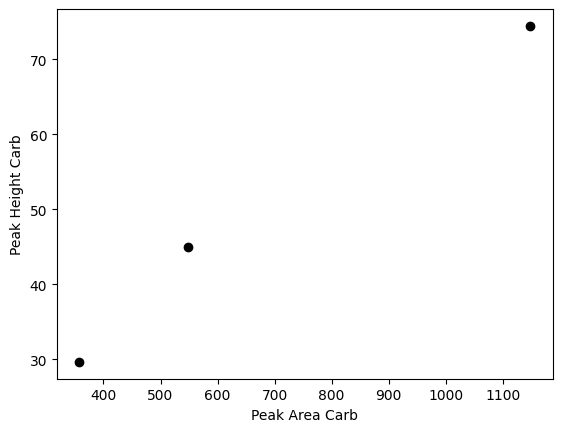

In [28]:
if sum(Carb_filter)>0:
    plt.plot(df_Merge_Carb['Peak_Area_Carb'], 
        df_Merge_Carb['Peak_Height_Carb'], 'ok')
    plt.xlabel('Peak Area Carb')
    plt.ylabel('Peak Height Carb')
# plt.yscale('log')
# plt.xscale('log')

## Save to excel

In [29]:
if sum(Carb_filter)>0:
    df_Merge_Carb['filename'] = df_Merge_Carb['filename'].str.replace('--Spec.Data 1', '')
    df_Merge_Carb.to_excel('Carb_Peak_fits.xlsx', index=False )

In [30]:
df_Merge_Carb

,filename,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name
0,09 187-1-201-MI1-rep1.txt,1095.363607,357.859870,29.636757,Spline
0,10 187-1-201-MI1-rep2.txt,1095.413038,548.162034,44.981907,Spline
0,37 187-1-205-MI1.txt,1093.485234,1148.329694,74.444943,Spline
